In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import jit
import optuna

### Data generation

In [110]:
err1s = []
err2s = []
err3s = []
err4s = []
err5s = []

In [111]:
x_dim = 5 # dimension of observations
freq = 0.2 # frequency of class 2 samples
mu_1 = 2*np.random.randn(x_dim,1) # mean of class 1
mu_2 = 2*np.random.randn(x_dim,1) # mean of class 2
sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T
samples = 10000 # number of data points

In [262]:
freq = 0.1 # frequency of class 2 samples

In [263]:
class_1 = mu_1 + sig@np.random.randn(x_dim,int(samples*(1-freq)))
class_2 = mu_2 + sig@np.random.randn(x_dim,int(samples*freq))

In [264]:
X = np.concatenate((class_1,class_2),axis=1)
Y = np.zeros((2,samples)); Y[0,:int(samples*(1-freq))] = 1; Y[1,-int(samples*freq):] = 1
idx = np.random.permutation(samples)
X = X[:,idx]
Y = Y[:,idx]

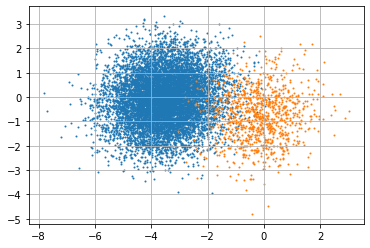

In [265]:
plt.scatter(class_1[0],class_1[1],s=1)
plt.scatter(class_2[0],class_2[1],s=1)
plt.grid()
plt.show()

### Optimal solution

In [266]:
w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

In [267]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

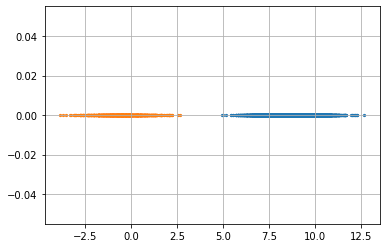

In [268]:
plt.scatter(w_opt.T@class_1,np.zeros((w_opt.T@class_1).shape),s=5)
plt.scatter(w_opt.T@class_2,np.zeros((w_opt.T@class_2).shape),s=5)
plt.grid()
plt.show()

### Offline algorithm

In [119]:
eta = 0.01; gam = 100*eta; iters = 10000

In [120]:
obj = np.zeros(iters)
err = np.zeros(iters)

@jit(nopython=True)
def fit(w, l, mu_1, mu_2, Sigma):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*((w.T@Sigma@w).item() - 1)
    
    return w, l
        
def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):
    
    w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
    l = 1
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l, mu_1, mu_2, Sigma)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt

run_offline(mu_1, mu_2, Sigma, eta, gam, iters)

100%|██████████| 10000/10000 [00:01<00:00, 7535.39it/s]


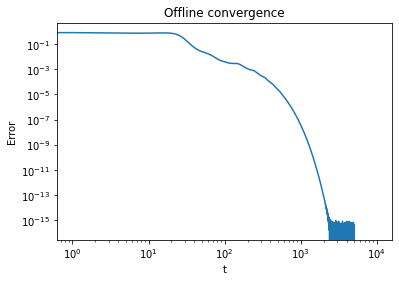

In [121]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

### Online algorithm

In [122]:
e = 1e-3
@jit(nopython=True)
def eta(t):
    return e/(1+e*t)
gam = 100; epochs = 25; iters = epochs*samples

In [126]:
@jit(nopython=True)
def fit_bio(w, l, mu, x, y, zeta, l_, t):
    wx = w.T@x
    z = wx
    
    step = eta(t)
    
    if y[1] == 0:
        mu += (x - mu)/t
        zeta += (z-zeta)/t
        w += step*(mu - l*(z-zeta)*(x-mu))
        l += gam*step*((z-zeta)**2 - 1)
        l_ += 1
        
    else:
        w -= step*l_*x
        l_ = 1
        
        
    return w, l, mu, x, y, zeta, l_

def run_bio(X, Y):
    
    w = np.random.randn(x_dim)/np.sqrt(x_dim)
    l = 1
    zeta = 0
    l_ = 1
    
    mu = np.zeros(x_dim)

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            w, l, mu, x, y, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, t)
            
            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

obj = np.zeros(iters)
err = np.zeros(iters)


def objective(trial):
   

    
    e = trial.suggest_discrete_uniform('eta', 4, 10, q=1)
    eta = 10**(-e)
    w = run_bio(X,Y, eta)
    obj_ = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
    return abs(obj_opt - obj_)/obj_opt

optimize = False
if optimize:
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)
else:
    #w = run_bio(X,Y)



100%|██████████| 25/25 [00:04<00:00,  7.64it/s]


In [127]:
err[-1]

0.0014325830555839394

In [272]:
#err3s = err3s[:-1]
#err5s = 
#err4s = err5s[:10]#
#err1s = err1s[:15]
len(err1s)

20

In [271]:
for i in range(5):
    obj = np.zeros(iters)
    err = np.zeros(iters)
    w = run_bio(X,Y)
    err1s.append(err)

100%|██████████| 25/25 [00:04<00:00,  6.35it/s]


In [223]:
def add_fill_lines(axis, t, err, plot_kwargs=None, ci_kwargs=None):
    """
    Parameters:
    ====================
    axis        -- Axis variable
    t           -- Array of time points
    err         -- The data matrix of errors over multiple trials
    plot_kwargs -- Arguments for axis.plot()
    ci_kwargs   -- Arguments for axis.fill_between()
    
    Output:
    ====================
    plot        -- Function axis.plot()
    fill        -- Function axis.fill_between() with standard deviation computed on a log scale
    """
        
    log_err = np.log(err+10**-5) # add 10**-5 to ensure the logarithm is well defined
    log_mu = log_err.mean(axis=0)
    sigma = np.std(log_err,axis=0)
    ci_lo, ci_hi = log_mu - sigma, log_mu + sigma
    plot_kwargs = plot_kwargs or {}
    ci_kwargs = ci_kwargs or {}
    plot = axis.loglog(t, np.exp(log_mu), **plot_kwargs)
    fill = axis.fill_between(t, np.exp(ci_lo), np.exp(ci_hi), alpha=.1, **ci_kwargs)
    
    return plot, fill

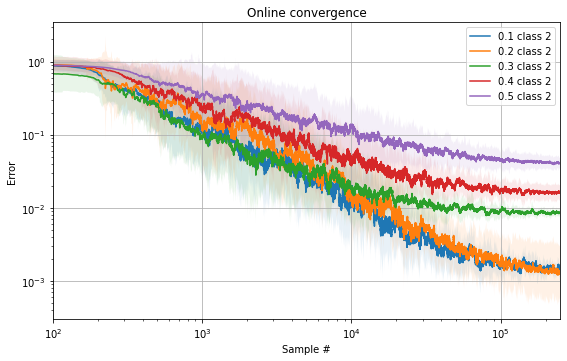

In [285]:
from matplotlib import gridspec
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])

add_fill_lines(ax1, range(iters), np.array(err1s), plot_kwargs = {"label": "0.1 class 2"})
add_fill_lines(ax1, range(iters), np.array(err2s), plot_kwargs = {"label": "0.2 class 2"})
add_fill_lines(ax1, range(iters), np.array(err3s), plot_kwargs = {"label": "0.3 class 2"})
add_fill_lines(ax1, range(iters), np.array(err4s), plot_kwargs = {"label": "0.4 class 2"})
add_fill_lines(ax1, range(iters), np.array(err5s), plot_kwargs = {"label": "0.5 class 2"})
plt.legend()
plt.title("Online convergence")
plt.ylabel("Error")
plt.xlabel("Sample #")
plt.xlim(1e2,iters)
plt.grid()
plt.show()

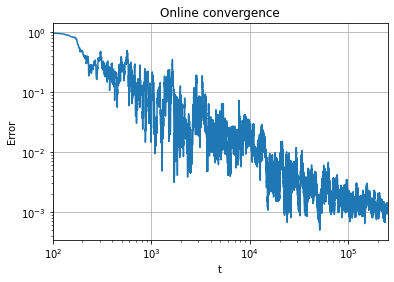

In [286]:
#err1s.append(err)
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.title("Online convergence")
plt.show()

In [201]:
np.mean(err1s, axis=0).shape

(250000,)

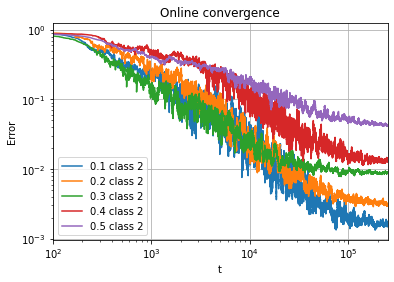

In [211]:
plt.errorbar(range(iters), np.mean(err1s, axis=0), label='0.1 class 2')
plt.errorbar(range(iters), np.mean(err2s, axis=0), label='0.2 class 2')
plt.errorbar(range(iters), np.mean(err3s, axis=0), label='0.3 class 2')
plt.errorbar(range(iters), np.mean(err4s, axis=0), label='0.4 class 2')
plt.errorbar(range(iters), np.mean(err5s, axis=0), label='0.5 class 2')
plt.ylabel("Error")
plt.yscale('log')
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.xscale('log')
plt.grid()
plt.legend()
plt.title("Online convergence")
plt.show()

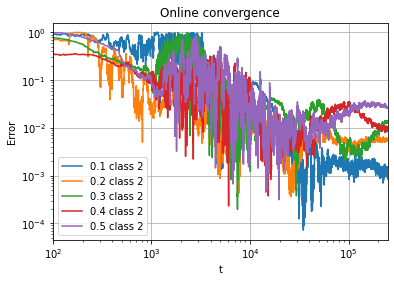

In [108]:
plt.loglog(range(iters), err1, label='0.1 class 2')
plt.loglog(range(iters), err2, label='0.2 class 2')
plt.loglog(range(iters), err3, label='0.3 class 2')
plt.loglog(range(iters), err4, label='0.4 class 2')
plt.loglog(range(iters), err5, label='0.5 class 2')
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.legend()
plt.title("Online convergence")
plt.show()

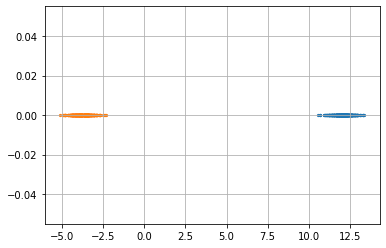

In [33]:
plt.scatter(w.T@class_1,np.zeros((w.T@class_1).shape),s=5)
plt.scatter(w.T@class_2,np.zeros((w.T@class_2).shape),s=5)
plt.grid()
plt.show()